## Purpose and Objective

The purpose of this data mining project is to study an issue that affects healthcare economics. The objective is to understand the dataset through EDA and use various machine learning models to predic payment trends.

In [1]:
#import libraries
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# for Mac errors
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

## Data Preprocessing

Clean and prepare data for data analysis


    1. Import Dataset
    2. Remove punctuations causing errors
    3. Convert attributes to proper data types
    4. Handle null values
    5. Handle payment column
    6. Establish metrics
    7. standardize numeric variables
    8. identify outliers

#### 1. Import Dataset

In [2]:
# load data
full_cbsa = pd.read_csv("cbsa2.csv")
full_cbsa.head(5)

,reference_period,type_of_service,aggregation_level,cbsa,cbsatitle,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,number_of_users,...,average_number_of_providers_per_cbsa_dual_color,average_number_of_providers_per_cbsa_description,number_of_dual_eligible_users_dual_color,number_of_dual_eligible_users_description,percentage_of_dual_eligible_users_out_of_total_users_dual_color,percentage_of_dual_eligible_users_out_of_total_users_description,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color_description,total_payment_dual_color,total_payment_description
0,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),NATION + TERRITORIES,--ALL--,--ALL--,"37,359,009","9,078",424.34,10.31%,"3,852,199",...,,,,,,,,,,
1,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10100,"Aberdeen, SD","7,526",3,231,9.21%,693,...,BLUE 1,Lowest 25% (Less than 5.00 Providers),BLUE 2,Second Lowest 25% (166 - 349 Dual Eligible Users),BLUE 2,Second Lowest 25% (21.67% - 26.95% of Total Us...,BLUE 3,Third Lowest 25% (17.06% - 19.32% of Total FFS...,BLUE 2,"Second Lowest 25% ($525,929.51 - $1,042,852.56 )"
2,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10140,"Aberdeen, WA","17,349",18,110.44,11.46%,"1,988",...,BLUE 4,Top 25% Excl. Extreme Values (16.00 - 32.49 Pr...,BLUE 3,Third Lowest 25% (350 - 845 Dual Eligible Users),BLUE 4,Top 25% Excl. Extreme Values (33.58% - 51.44% ...,BLUE 4,Top 25% Excl. Extreme Values (19.33% - 27.78% ...,BLUE 3,"Third Lowest 25% ($1,042,852.57 - $2,686,138.28 )"
3,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10180,"Abilene, TX","25,198",11,271.09,11.83%,"2,982",...,BLUE 3,Third Lowest 25% (9.00 - 15.99 Providers),BLUE 4,"Top 25% Excl. Extreme Values (846 - 1,864 Dual...",BLUE 3,Third Lowest 25% (26.96% - 33.57% of Total Users),BLUE 4,Top 25% Excl. Extreme Values (19.33% - 27.78% ...,BLUE 3,"Third Lowest 25% ($1,042,852.57 - $2,686,138.28 )"
4,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10220,"Ada, OK","7,570",5,104.8,6.92%,524,...,BLUE 2,Second Lowest 25% (5.00 - 8.99 Providers),BLUE 2,Second Lowest 25% (166 - 349 Dual Eligible Users),BLUE 4,Top 25% Excl. Extreme Values (33.58% - 51.44% ...,BLUE 1,Lowest 25% (Less than 13.69% of Total FFS Bene...,BLUE 1,"Lowest 25% (Less than $525,929.51 )"


In [3]:
full_cbsa.shape

(163035, 35)

In [4]:
cbsa = full_cbsa.iloc[:, :15]
cbsa.head()

,reference_period,type_of_service,aggregation_level,cbsa,cbsatitle,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,number_of_users,average_number_of_providers_per_cbsa,number_of_dual_eligible_users,percentage_of_dual_eligible_users_out_of_total_users,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,total_payment
0,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),NATION + TERRITORIES,--ALL--,--ALL--,"37,359,009","9,078",424.34,10.31%,"3,852,199",116.56,"1,085,184",28.17%,17.24%,"$3,430,203,620.67"
1,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10100,"Aberdeen, SD","7,526",3,231,9.21%,693,3,174,25.11%,18.73%,"$588,150.97"
2,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10140,"Aberdeen, WA","17,349",18,110.44,11.46%,"1,988",18,675,33.95%,19.55%,"$1,786,700.58"
3,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10180,"Abilene, TX","25,198",11,271.09,11.83%,"2,982",11,907,30.42%,19.76%,"$2,003,346.18"
4,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10220,"Ada, OK","7,570",5,104.8,6.92%,524,5,183,34.92%,12.12%,"$359,960.14"


<table style="border:1px solid black;">
  <tr>
    <th width="200px" style="background-color: lightgrey; border:1px solid black;">Quantitative (interval)</th>
    <th width="200px" style="background-color: lightgrey; border:1px solid black;">Quantitative (ratio)   </th>
  </tr>
  <tr>
    <td style="background-color: lightblue; vertical-align: top; border:1px solid black;">reference_period</td>
    <td style="background-color: lightblue; vertical-align: top; border:1px solid black;">number_of_fee_for_service_beneficiaries,
number_of_providers,
average_number_of_users_per_provider,
percentage_of_users_out_of_ffs_beneficiaries,
number_of_users,
average_number_of_providers_per_cbsa,
number_of_dual_eligible_users,
percentage_of_dual_eligible_users_out_of_total_users,
percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,
total_payment
</td>
  </tr>
</table>

<table>
  <tr>
    <th width="200px" style="background-color: lightgrey; border:1px solid black;">Qualitative (nominal)</th>
    <th width="200px" style="background-color: lightgrey; border:1px solid black;">Qualitative (ordinal)</th>
  </tr>
  <tr>
    <td style="background-color: lightblue; vertical-align: top; border:1px solid black;">type_of_service,
cbsa,
cbsatitle
    <td style="background-color: lightblue; vertical-align: top; border:1px solid black;">
aggregation_level
    </td>
  </tr>
</table>

#### 2. Remove Punctuations

In [5]:
# remove percent and dollar signs
cbsa = cbsa.replace('%', '', regex=True)
cbsa = cbsa.replace('\$', '', regex=True)

# remove aggregate
cbsa = cbsa[cbsa['cbsa'] != '--ALL--']

In [6]:
# split reference period to start and end dates
cbsa[['city', 'state']] = cbsa['cbsatitle'].str.split(', ', expand=True)
cbsa.insert(0, 'state', cbsa.pop('state'))
cbsa.insert(0, 'city', cbsa.pop('city'))
# cbsa.drop(["cbsatitle"], axis = 1, inplace= True)

In [7]:
# split reference period to start and end dates
cbsa[['start_date', 'end_date']] = cbsa['reference_period'].str.split(' to ', expand=True)
cbsa.insert(0, 'end_date', cbsa.pop('end_date'))
cbsa.insert(0, 'start_date', cbsa.pop('start_date'))
cbsa.drop(["reference_period"], axis = 1, inplace= True)

#### 3. Convert Attributes

In [8]:
# convert date columns to datetime
cbsa[['start_date', 'end_date']] = cbsa[['start_date', 'end_date']].apply(pd.to_datetime)

In [9]:
# convert numerical variables to integer or float
convert_numerical = [
    'number_of_fee_for_service_beneficiaries',
    'number_of_providers',
    'number_of_users',
    'number_of_dual_eligible_users',
    'average_number_of_users_per_provider',
    'percentage_of_users_out_of_ffs_beneficiaries',
    'average_number_of_providers_per_cbsa',
    'percentage_of_dual_eligible_users_out_of_total_users',
    'percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries',
    'total_payment'
]

for column in convert_numerical:
    cbsa[column] = cbsa[column].str.replace(' ', '').str.replace(',', '')
    cbsa[column] = pd.to_numeric(cbsa[column], downcast=None)

In [10]:
# identify and convert to categorical
convert_to_category = [
    'type_of_service',
    'cbsa',
    'cbsatitle',
    'city',
    'state',
    'aggregation_level',
]
cbsa[convert_to_category] = cbsa[convert_to_category].astype('category')

In [11]:
# confirm datatypes
print(cbsa.dtypes)

start_date                                                                  datetime64[ns]
end_date                                                                    datetime64[ns]
city                                                                              category
state                                                                             category
type_of_service                                                                   category
aggregation_level                                                                 category
cbsa                                                                              category
cbsatitle                                                                         category
number_of_fee_for_service_beneficiaries                                              int64
number_of_providers                                                                  int64
average_number_of_users_per_provider                                               float64

In [12]:
## Dictionary
cbsa_dict={1:"Start of The selected one-year time period of observations",
2:"End of the selected one-year time period of observations",
3:"City of the CBSA",
4:"State or Territory of the CBSA",
5:"The selected health service area",
6:"A variable classifying the observation as the State, County, CBSA or Nation + Territories level",
7:"Five digit code to specify CBSA to indicate Nation + Territories level",
8:"CBSA name to indicate Nation + Territories",
9:"Total number of FFS beneficiaries in selected geographic region for specified reference period and service area",
10:"Total number of providers in selected geographic region for specified reference period and service area",
11:"The average number of users per provider in selected geographic region for specified reference period and service area",
12:"The percentage of users out of FFS beneficiaries in selected geographic region for specified reference period and service area",
13:"The total number of users in selected geographic region for specified reference period and service area",
14:"The average number of providers per CBSA for specified reference period and service area. Only populated for CBSAs",
15:"The number of users qualifying for Medicare and any level of Medicaid coverage in selected geographic region for specified reference period and service area",
16:"The percentage of dual eligible users out of the total number of users in selected geographic region for specified reference period and service area",
17:"The percentage of dual eligible users out of the total number FFS beneficiaries in selected geographic region for specified reference period and service area",
18:"The total payment in selected geographic region for specified reference period and service area"}

#### 4. Handle Null Values

In [13]:
# check null values
cbsa.isnull().sum()

start_date                                                                      0
end_date                                                                        0
city                                                                            0
state                                                                           0
type_of_service                                                                 0
aggregation_level                                                               0
cbsa                                                                            0
cbsatitle                                                                       0
number_of_fee_for_service_beneficiaries                                         0
number_of_providers                                                             0
average_number_of_users_per_provider                                         3812
percentage_of_users_out_of_ffs_beneficiaries                                    0
number_of_users 

In [14]:
# check if cbsa have sufficient users to qualify
cbsa.loc[cbsa['number_of_users'] == cbsa['number_of_users'].min(),'number_of_users']

765       11
1949      11
2815      11
3288      11
3713      11
          ..
156802    11
156975    11
159581    11
162312    11
162479    11
Name: number_of_users, Length: 320, dtype: int64

**Observation:** The lowest number of user is 11, meaning the providers should be defined by CMS. Requirement is 10 and above. There appears to be many that are close to the cutoff. There may have been technicalities that did not qualify the providers according to CMS criteria.

**Investigate `average_number_of_users_per_provider`**

In [15]:
# impute number providers of 0 with previous data
cbsa['number_of_providers'].replace(0, np.nan, inplace=True)

In [16]:
# create a subset of cbsa with complete dual data
provider_subset = ['start_date','type_of_service','cbsa','number_of_providers']

cbsa_provider = cbsa[provider_subset].sort_values('start_date').dropna().drop_duplicates(
    subset=['type_of_service', 'cbsa'], keep='last')

In [17]:
# fill missing values with the most recent available data
match_cols1 = ['cbsa','type_of_service']
cbsa = cbsa.set_index(match_cols1).fillna(cbsa_provider.set_index(match_cols1)).reset_index()

In [18]:
# cbsa.to_csv('cbsa_providernum.csv', index=False)

In [19]:
# due to provider circumstances 0
cbsa['number_of_providers'] = cbsa['number_of_providers'].fillna(0)

**Identify and remove outliers, under conditions that number of users are 10 but provider is 0**

**Investigate `number_of_dual_eligible_users`**

    - replace missing values with same data from the most recent previous reference period
    - estimate number of dual eligible using average qualifiers per type of sertice

In [20]:
# create a subset of cbsa with complete dual data
dual_subset = ['start_date','type_of_service','cbsa','number_of_dual_eligible_users']

cbsa_dual = cbsa[dual_subset].sort_values('start_date').dropna().drop_duplicates(
    subset=['type_of_service', 'cbsa'], keep='last')

In [21]:
# fill missing values with the most recent available data
match_cols2 = ['cbsa','type_of_service']
cbsa = cbsa.set_index(match_cols2).fillna(cbsa_dual.set_index(match_cols2)).reset_index()

In [22]:
# aggregate mean of percentage_of_dual_eligible_users_out_of_total_users per service type

mean_percentage_service = cbsa.groupby('type_of_service')['percentage_of_dual_eligible_users_out_of_total_users'].mean()
mean_percentage_service = mean_percentage_service.reset_index()
mean_percentage_service

,type_of_service,percentage_of_dual_eligible_users_out_of_total_users
0,Ambulance (Emergency & Non-Emergency),27.484972
1,Ambulance (Emergency),27.981974
2,Ambulance (Non-Emergency),29.584675
3,Cardiac Rehabilitation Program,12.125258
4,Chiropractic Services,8.943611
5,Clinical Laboratory (Billing Independently),18.059210
6,Dialysis,39.513165
7,Federally Qualified Health Center (FQHC),45.332903
8,Home Health,21.352746
9,Hospice,20.758439


In [23]:
match_mean_dual_service = ['type_of_service']
cbsa = cbsa.set_index(match_mean_dual_service).fillna(mean_percentage_service.set_index(match_mean_dual_service)).reset_index()

In [24]:
# fill nulls of average_number_of_users_per_provider with num users/num providers
fill_avg_users_per_provider = cbsa['number_of_users']/cbsa['number_of_providers']
cbsa['average_number_of_users_per_provider'].fillna(fill_avg_users_per_provider, inplace=True)
cbsa['average_number_of_users_per_provider'].replace(np.inf, 0, inplace=True)

In [25]:
# fill nulls of number_of_dual_eligible_users by average number per service type
fill_dual_users = cbsa['number_of_users']*(cbsa[
    'percentage_of_dual_eligible_users_out_of_total_users']/100)
cbsa['number_of_dual_eligible_users'].fillna(fill_dual_users, inplace=True)

In [26]:
cbsa['percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries'] = cbsa[
    'number_of_dual_eligible_users']/cbsa['number_of_fee_for_service_beneficiaries']

In [27]:
# check null values
cbsa.isnull().sum()

type_of_service                                                             0
cbsa                                                                        0
start_date                                                                  0
end_date                                                                    0
city                                                                        0
state                                                                       0
aggregation_level                                                           0
cbsatitle                                                                   0
number_of_fee_for_service_beneficiaries                                     0
number_of_providers                                                         0
average_number_of_users_per_provider                                        0
percentage_of_users_out_of_ffs_beneficiaries                                0
number_of_users                                                 

In [28]:
# cbsa.to_csv('cbsa_providerv5.csv', index=False)

Number of Fee-For-Service (FFS) Beneficiaries, Number of Providers, Number of Users, Number of Dual Eligible Users, Total Payment, reference_period, type_of_service, cbsa 

    - box plots of different services of ONE CBSA's independent diagnostic. measured by total_payment

In [29]:
users_per_service = cbsa.groupby('type_of_service')['number_of_users'].sum()
users_per_service

type_of_service
Ambulance (Emergency & Non-Emergency)            31901593
Ambulance (Emergency)                            28738527
Ambulance (Non-Emergency)                        11196196
Cardiac Rehabilitation Program                    1179525
Chiropractic Services                            10711675
Clinical Laboratory (Billing Independently)     124559121
Dialysis                                          2504261
Federally Qualified Health Center (FQHC)         10936339
Home Health                                      22853273
Hospice                                           6755417
Independent Diagnostic Testing Facility Pt A    134015716
Independent Diagnostic Testing Facility Pt B     17716716
Long-Term Care Hospitals                           486651
Ophthalmology                                    97240318
Physical & Occupational Therapy                  24448431
Podiatry Services                                38730450
Preventive Health Services                      16922376

In [30]:
# filter all the long-term care hospitals in the dataset
long_term_subset = cbsa[cbsa['type_of_service'] =='Long-Term Care Hospitals']

# filter the top 10 with the largest total payment
top_lt = long_term_subset.nlargest(10, 'total_payment')

# how many times the same CBSA appeared in the top 10
top_cbsa_lt = top_lt['cbsatitle'].value_counts()
top_cbsa_lt

cbsatitle
Los Angeles-Long Beach-Anaheim, CA      7
Houston-The Woodlands-Sugar Land, TX    2
Dallas-Fort Worth-Arlington, TX         1
Aberdeen, SD                            0
Orangeburg, SC                          0
                                       ..
Gainesville, TX                         0
Galesburg, IL                           0
Gallup, NM                              0
Garden City, KS                         0
Zapata, TX                              0
Name: count, Length: 1006, dtype: int64

In [31]:
cbsa['cbsatitle'].nunique()

1006

In [32]:
unique_states = cbsa['state'].unique()
unique_states
# for state in unique_states:
#    print (state)

['SD', 'WA', 'TX', 'OK', 'MI', ..., 'VA-NC', 'DC-VA-MD-WV', 'VA-WV', 'MA-CT', 'OH-PA']
Length: 102
Categories (102, object): ['AK', 'AL', 'AL-GA', 'AR', ..., 'WV-OH', 'WV-VA', 'WY', 'WY-ID']

**Observation:** some providers were 0 and therfefore error calculating `average_number_of_users_per_provider`.

Number of Fee-For-Service (FFS) Beneficiaries, Number of Providers, Number of Users, Number of Dual Eligible Users, Total Payment, reference_period, type_of_service, cbsa

All service types will be aggregated, box plot, compared by payment. Isolate and examine which has the most outliers.

#### 5. Handle `total_payment` to ensure  comparability across CBSA

**Apply Cost of Health Index to `total_payment`**

In [33]:
# cost of health index dictionary
cost_index = {
    'AK' : 1.48,
    'AL' : 0.87,
    'AL-GA' : 0.87,
    'AR' : 0.88,
    'AR-MO' : 0.88,
    'AR-OK' : 0.88,
    'AZ' : 0.94,
    'CA' : 1.09,
    'CO' : 1.00,
    'CT' : 1.09,
    'DC-VA-MD-WV' : 1.47,
    'DE' : 1.03,
    'FL' : 0.97,
    'GA' : 1.00,
    'GA-AL' : 1.00,
    'GA-SC' : 0.91,
    'HI' : 1.23,
    'IA' : 0.99,
    'IA-IL' : 0.99,
    'IA-IL-MO' : 0.99,
    'IA-NE-SD' : 0.99,
    'ID' : 0.99,
    'ID-WA' : 0.99,
    'IL' : 0.95,
    'IL-IN-WI' : 0.95,
    'IL-MO' : 0.95,
    'IN' : 0.96,
    'IN-KY' : 0.96,
    'IN-MI' : 0.96,
    'KS' : 0.97,
    'KY' : 0.84,
    'KY-IL' : 0.84,
    'KY-IN' : 0.84,
    'LA' : 0.99,
    'MA' : 1.13,
    'MA-CT' : 1.13,
    'MA-NH' : 1.13,
    'MD' : 0.97,
    'MD-DE' : 0.97,
    'MD-WV' : 0.97,
    'ME' : 1.03,
    'MI' : 0.93,
    'MI-WI' : 0.93,
    'MN' : 1.09,
    'MN-WI' : 1.09,
    'MO' : 0.90,
    'MO-IL' : 0.90,
    'MO-KS' : 0.90,
    'MS' : 0.98,
    'MS-LA' : 0.98,
    'MT' : 0.98,
    'NC' : 1.08,
    'NC-SC' : 1.08,
    'ND' : 1.11,
    'ND-MN' : 1.11,
    'NE' : 0.98,
    'NE-IA' : 0.98,
    'NH' : 1.13,
    'NH-VT' : 1.13,
    'NJ' : 0.99,
    'NM' : 0.99,
    'NV' : 0.92,
    'NY' : 1.06,
    'NY-NJ-PA' : 1.06,
    'OH' : 0.98,
    'OH-KY-IN' : 0.98,
    'OH-PA' : 0.98,
    'OK' : 0.93,
    'OR' : 1.05,
    'OR-ID' : 1.05,
    'OR-WA' : 1.05,
    'PA' : 0.94,
    'PA-NJ' : 0.96,
    'PA-NJ-DE-MD' : 0.94,
    'PR' : 0.69,
    'RI-MA' : 1.08,
    'SC' : 0.95,
    'SC-NC' : 0.95,
    'SD' : 0.98,
    'TN' : 0.88,
    'TN-GA' : 0.88,
    'TN-KY' : 0.88,
    'TN-MS-AR' : 0.88,
    'TN-VA' : 0.88,
    'TX' : 0.94,
    'TX-AR' : 0.94,
    'UT' : 0.91,
    'UT-ID' : 0.91,
    'VA' : 1.02,
    'VA-NC' : 1.02,
    'VA-WV' : 1.02,
    'VT' : 1.06,
    'WA' : 1.20,
    'WI' : 1.12,
    'WI-MI' : 1.12,
    'WI-MN' : 1.12,
    'WV' : 0.97,
    'WV-KY-OH' : 0.97,
    'WV-OH' : 0.97,
    'WV-VA' : 0.97,
    'WY' : 1.00,
    'WY-ID' : 1.00
}

In [34]:
# use dictionary to map states to their cost of health index
cbsa['cost_of_health_index'] = cbsa['state'].map(cost_index)
cbsa['total_payment_adjusted'] = cbsa['total_payment']*cbsa['cost_of_health_index']
cbsa.head()

,type_of_service,cbsa,start_date,end_date,city,state,aggregation_level,cbsatitle,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,number_of_users,average_number_of_providers_per_cbsa,number_of_dual_eligible_users,percentage_of_dual_eligible_users_out_of_total_users,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,total_payment,cost_of_health_index,total_payment_adjusted
0,Ambulance (Emergency & Non-Emergency),10100,2015-01-01,2015-12-31,Aberdeen,SD,CBSA,"Aberdeen, SD",7526,3.0,231.00,9.21,693,3.0,174.0,25.11,0.023120,588150.97,0.98,5.763880e+05
1,Ambulance (Emergency & Non-Emergency),10140,2015-01-01,2015-12-31,Aberdeen,WA,CBSA,"Aberdeen, WA",17349,18.0,110.44,11.46,1988,18.0,675.0,33.95,0.038907,1786700.58,1.20,2.144041e+06
2,Ambulance (Emergency & Non-Emergency),10180,2015-01-01,2015-12-31,Abilene,TX,CBSA,"Abilene, TX",25198,11.0,271.09,11.83,2982,11.0,907.0,30.42,0.035995,2003346.18,0.94,1.883145e+06
3,Ambulance (Emergency & Non-Emergency),10220,2015-01-01,2015-12-31,Ada,OK,CBSA,"Ada, OK",7570,5.0,104.80,6.92,524,5.0,183.0,34.92,0.024174,359960.14,0.93,3.347629e+05
4,Ambulance (Emergency & Non-Emergency),10300,2015-01-01,2015-12-31,Adrian,MI,CBSA,"Adrian, MI",16863,18.0,103.94,11.10,1871,18.0,529.0,28.27,0.031370,1524406.98,0.93,1.417698e+06


**Normalize `total_payment_adjusted` by health service utilization**

In [35]:
cbsa['total_payment_adj_z'] = cbsa['total_payment_adjusted']/cbsa['number_of_users']
cbsa.head()

,type_of_service,cbsa,start_date,end_date,city,state,aggregation_level,cbsatitle,number_of_fee_for_service_beneficiaries,number_of_providers,...,percentage_of_users_out_of_ffs_beneficiaries,number_of_users,average_number_of_providers_per_cbsa,number_of_dual_eligible_users,percentage_of_dual_eligible_users_out_of_total_users,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,total_payment,cost_of_health_index,total_payment_adjusted,total_payment_adj_z
0,Ambulance (Emergency & Non-Emergency),10100,2015-01-01,2015-12-31,Aberdeen,SD,CBSA,"Aberdeen, SD",7526,3.0,...,9.21,693,3.0,174.0,25.11,0.023120,588150.97,0.98,5.763880e+05,831.728644
1,Ambulance (Emergency & Non-Emergency),10140,2015-01-01,2015-12-31,Aberdeen,WA,CBSA,"Aberdeen, WA",17349,18.0,...,11.46,1988,18.0,675.0,33.95,0.038907,1786700.58,1.20,2.144041e+06,1078.491296
2,Ambulance (Emergency & Non-Emergency),10180,2015-01-01,2015-12-31,Abilene,TX,CBSA,"Abilene, TX",25198,11.0,...,11.83,2982,11.0,907.0,30.42,0.035995,2003346.18,0.94,1.883145e+06,631.504161
3,Ambulance (Emergency & Non-Emergency),10220,2015-01-01,2015-12-31,Ada,OK,CBSA,"Ada, OK",7570,5.0,...,6.92,524,5.0,183.0,34.92,0.024174,359960.14,0.93,3.347629e+05,638.860554
4,Ambulance (Emergency & Non-Emergency),10300,2015-01-01,2015-12-31,Adrian,MI,CBSA,"Adrian, MI",16863,18.0,...,11.10,1871,18.0,529.0,28.27,0.031370,1524406.98,0.93,1.417698e+06,757.722336


In [36]:
# statistics
cbsa.describe()

,start_date,end_date,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,number_of_users,average_number_of_providers_per_cbsa,number_of_dual_eligible_users,percentage_of_dual_eligible_users_out_of_total_users,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,total_payment,cost_of_health_index,total_payment_adjusted,total_payment_adj_z
count,162848,162848,1.628480e+05,162848.000000,162848.000000,162848.000000,1.628480e+05,162848.000000,162848.000000,162848.000000,162848.000000,1.628480e+05,162848.00000,1.628480e+05,162848.000000
mean,2019-01-12 09:51:07.144822016,2020-01-11 15:09:18.145018624,3.876744e+04,50.151767,113.162370,12.941694,5.105435e+03,50.072258,930.209669,23.232540,0.023898,1.158631e+07,0.98537,1.171921e+07,8359.039088
min,2015-01-01 00:00:00,2015-12-31 00:00:00,4.070000e+02,0.000000,0.000000,0.010000,1.100000e+01,0.000000,0.983797,0.470000,0.000022,5.953100e+02,0.69000,4.107639e+02,26.666471
25%,2017-01-01 00:00:00,2017-12-31 00:00:00,6.180000e+03,4.000000,41.000000,2.560000,2.380000e+02,4.000000,47.000000,12.730000,0.004694,2.189874e+05,0.94000,2.141422e+05,249.431556
50%,2019-01-01 00:00:00,2019-12-31 00:00:00,1.196600e+04,10.000000,64.960000,5.890000,8.010000e+02,10.000000,159.000000,20.240000,0.012421,9.170519e+05,0.98000,8.994380e+05,652.130172
75%,2021-01-01 00:00:00,2021-12-31 00:00:00,2.689500e+04,28.000000,128.000000,15.610000,2.830000e+03,28.000000,517.000000,30.780000,0.030779,4.449768e+06,1.02000,4.411305e+06,5864.095093
max,2023-01-01 00:00:00,2023-12-31 00:00:00,2.523066e+06,16732.000000,2581.130000,75.080000,1.421406e+06,16732.000000,231507.000000,100.000000,0.496762,6.625352e+09,1.48000,7.022873e+09,358333.097520
std,NaN,NaN,1.176749e+05,278.113821,136.809881,15.949473,2.603557e+04,278.108241,5092.474592,13.727376,0.031046,8.285980e+07,0.08800,8.663620e+07,18017.080283


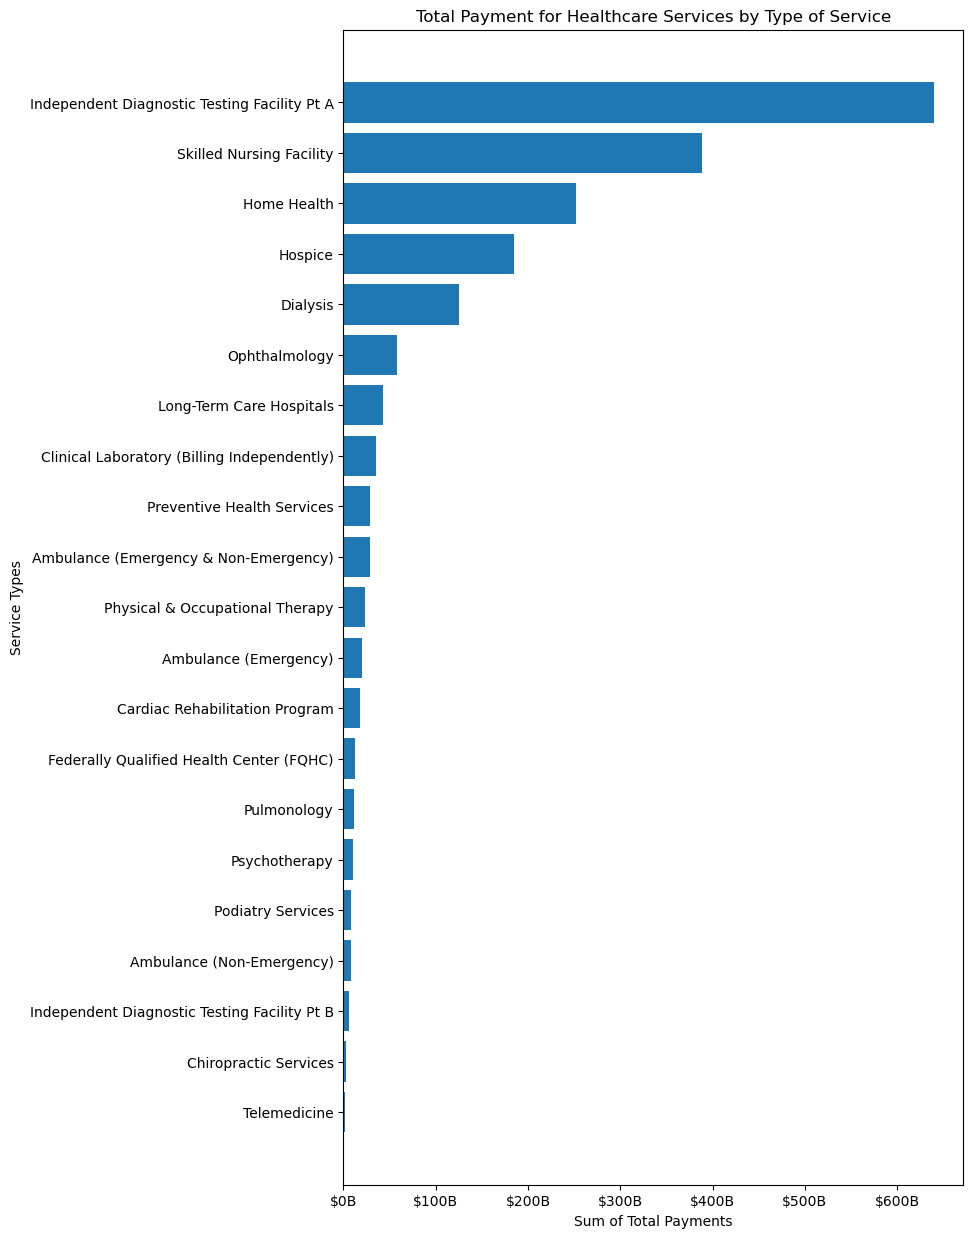

In [39]:
# visualization to see the total payment across different service types
service_payment = cbsa.groupby('type_of_service', as_index=False)['total_payment_adjusted'].sum()
service_payment.sort_values(by = ['total_payment_adjusted'], inplace=True)
fig = plt.figure(figsize = (8,15))
plt.barh(service_payment['type_of_service'], service_payment['total_payment_adjusted'])
plt.title("Total Payment for Healthcare Services by Type of Service")
plt.xlabel("Sum of Total Payments")
plt.ylabel("Service Types")

# format x-axis for readability
def format_dollars(x, pos):
    return '${:,.0f}B'.format(x/1e9)
    
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_dollars))
plt.show()

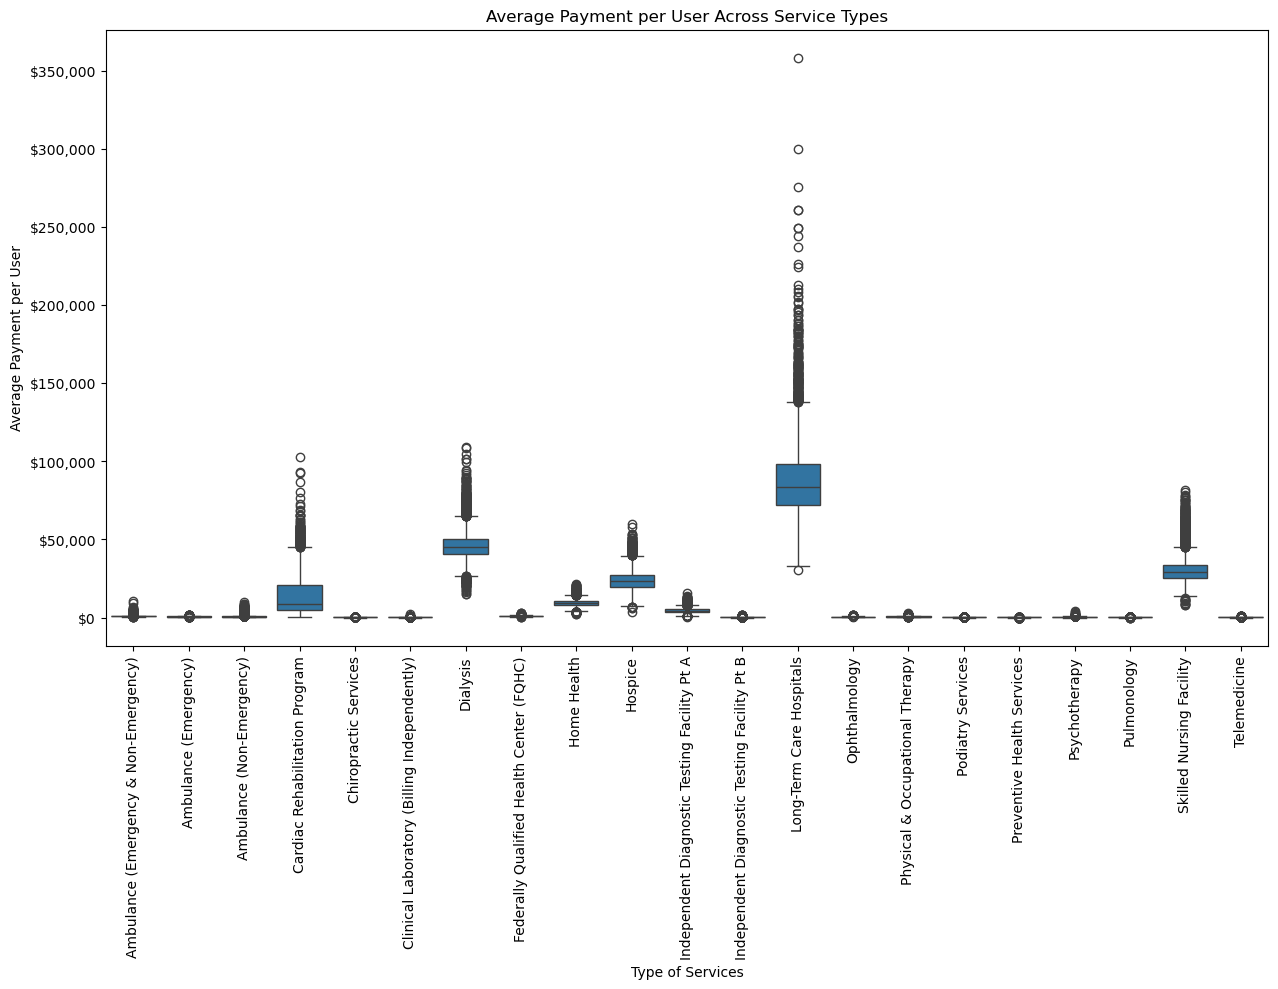

In [38]:
plt.figure(figsize=(15,8))
sns.boxplot(x='type_of_service', y='total_payment_adj_z', data= cbsa)
plt.title('Average Payment per User Across Service Types')
plt.xlabel('Type of Services')
plt.ylabel('Average Payment per User')
plt.xticks(rotation=90)

# format y-axis for readability
def format_dollars(y, pos):
    return '${:,.0f}'.format(y)
    
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_dollars))


plt.show()

#### 6. Establish Metrics

#### 7. Standardize Remaining Numeric Values

#### 8. Identify and Examine Outliers

## Determine Data Mining Task


    1. Analyze and find correlation between features
    2. Build and test machine learning models
    3. Select best performing model
    4. Feature importance
    5. Deployment Planning

## Choose Data Mining Methods

## Apply Methods and Select Final Model

## Evaluate Performance